In [5]:
#Librairie
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV

from tensorflow.keras import layers, models
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import BatchNormalization, Activation
import optuna
import tensorflow as tf
from optuna.integration import TFKerasPruningCallback



C:\Users\Romain G\AppData\Roaming\Python\Python312\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


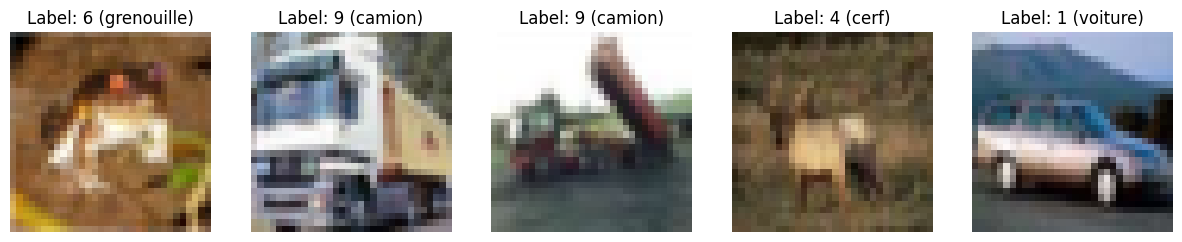

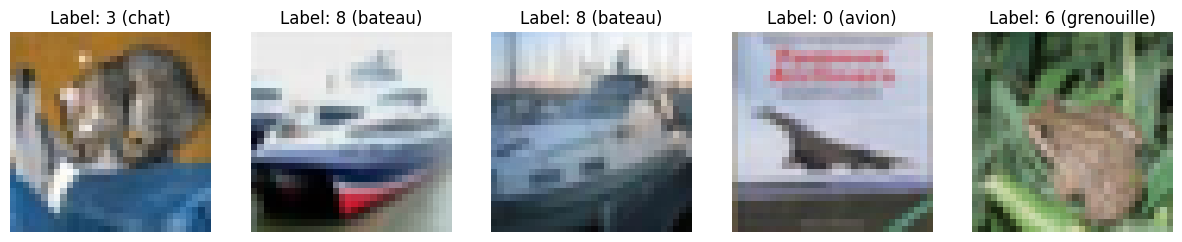

In [6]:
#Importation Dataset CIFAR-10
#Obligatoire
import tensorflow as tf

(x_train_t, y_train_t), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()

#Split le data set en train et en validation (pour les CNN)

N_train_t = np.shape(x_train_t)[0]
N_train = round(0.8*N_train_t) # 80% pour le train et 20% pour la validation
x_train,y_train = x_train_t[0:N_train],y_train_t[0:N_train]
x_val,y_val = x_train_t[N_train:],y_train_t[N_train:]


#Normalisation des images

x_train, x_val, x_test = x_train / 255.0, x_val / 255.0, x_test / 255.0


cifar10_labels = ['avion', 'voiture', 'oiseau', 'chat', 'cerf', 'chien', 'grenouille', 'cheval', 'bateau', 'camion']

plt.figure(figsize=(15,3)) 
for i in range(5):
    plt.subplot(1,5,i+1)
    plt.imshow(x_train[i])
    label_index = y_train[i][0] if isinstance(y_train[i], np.ndarray) else y_train[i]
    plt.title(f"Label: {label_index} ({cifar10_labels[label_index]})")
    plt.axis('off')
plt.show()

plt.figure(figsize=(15,3)) 
for i in range(5):
    plt.subplot(1,5,i+1)
    plt.imshow(x_test[i])
    label_index = y_test[i][0] if isinstance(y_test[i], np.ndarray) else y_test[i]
    plt.title(f"Label: {label_index} ({cifar10_labels[label_index]})")
    plt.axis('off')
plt.show()




In [ ]:
#Algo de ML : Decision Tree 

x_train_flat = x_train_t.reshape((x_train_t.shape[0], -1))
x_test_flat = x_test.reshape((x_test.shape[0], -1))

scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train_flat)
x_test_scaled = scaler.transform(x_test_flat)

arbre = DecisionTreeClassifier(max_depth=10, criterion='gini', min_samples_split=20, random_state=44)
arbre.fit(x_train_scaled, y_train_t.ravel())
'''
param_grid = {
    'max_depth': [5, 10, 20],
    'min_samples_split': [2, 10, 20],
    'criterion': ['gini', 'entropy']
}

# GridSearch avec validation croisée 3-fold
grid_search = GridSearchCV(arbre, param_grid, cv=3)
grid_search.fit(x_train_scaled, y_train_t.ravel())
'''
y_pred = arbre.predict(x_test_scaled)
acc = accuracy_score(y_test, y_pred)
recall = recall_score(y_test, y_pred, average='macro')  # Calcul du rappel
print(f"Précision de l'arbre de décision sur CIFAR-10 : {acc:.2f}")
print(f"Rappel de l'arbre de décision sur CIFAR-10 : {recall:.2f}")

In [ ]:
#Foret Aleatoire 
rf = RandomForestClassifier(n_estimators=100, random_state=42)

# Entraînement du modèle
rf.fit(x_train_scaled, y_train_t.ravel())

# Prédiction et évaluation
y_pred = rf.predict(x_test_scaled)
acc = accuracy_score(y_test, y_pred)
recall = recall_score(y_test, y_pred, average='macro')  # Calcul du rappel
print(f"Précision de la forêt aléatoire sur CIFAR-10 : {acc:.2f}")
print(f"Rappel de la forêt aléatoire sur CIFAR-10 : {recall:.2f}")

Précision de la forêt aléatoire sur CIFAR-10 : 0.10
Rappel de la forêt aléatoire sur CIFAR-10 : 0.10


In [7]:
#3 CNN aux architectures différentes
#Obligatoire
# Redimensionner les images (32x32 -> 32x32x1) pour la convolution
x_train = x_train.reshape(-1, 32, 32, 3)
x_val = x_val.reshape(-1, 32, 32, 3)
x_test = x_test.reshape(-1, 32, 32, 3)
# Encodage One-Hot des labels
y_train_c = to_categorical(y_train, 10)
y_val_c = to_categorical(y_val, 10)
y_test_c = to_categorical(y_test, 10)

In [ ]:

# Optuna pour déterminer le meilleur combo epochs/batch size

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
def create_classic_cnn_model(input_shape, learning_rate):
    model = Sequential([
        Conv2D(32, (3,3), activation='relu', input_shape=input_shape),
        MaxPooling2D(2,2),
        Conv2D(64, (3,3), activation='relu'),
        MaxPooling2D(2,2),
        Flatten(),
        Dense(128, activation='relu'),
        Dense(10, activation='softmax') 
    ])
    
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
        loss='categorical_crossentropy',
        metrics=['accuracy','recall']
    )
    return model

def objective_cnn_classique(trial):
    # Hyperparamètres testés
    epochs = trial.suggest_int('epochs', 10, 30)
    batch_size = trial.suggest_categorical('batch_size', [32, 64, 128])
    learning_rate = trial.suggest_float('learning_rate', 1e-4, 1e-2, log=True)

    tf.keras.backend.clear_session()

    model = create_classic_cnn_model(input_shape=x_train.shape[1:], learning_rate=learning_rate)

    # Callbacks
    early_stopping_optuna = EarlyStopping(
        monitor='val_accuracy', 
        patience=7,         
        restore_best_weights=True,
        mode='max'          
    )
    pruning_callback = TFKerasPruningCallback(trial, 'val_accuracy')

    print(f"\nTrial {trial.number}: epochs={epochs}, batch_size={batch_size}, lr={learning_rate:.5f}")

    # Entraîner le modèle
    history = model.fit(
        x_train, y_train_c,
        validation_data=(x_val, y_val_c),
        epochs=epochs,
        batch_size=batch_size,
        callbacks=[early_stopping_optuna, pruning_callback],
        verbose=0 
    )

    
    val_accuracy = max(history.history['val_accuracy']) 
    
   
    if not history.history['val_accuracy']:
        return 0.0 

    return val_accuracy


# Le pruner aide à arrêter les essais non prometteurs plus tôt pr éviter que ce soit trop long
study_cnn_classique = optuna.create_study(direction='maximize', pruner=optuna.pruners.MedianPruner())
study_cnn_classique.optimize(objective_cnn_classique, n_trials=20) 

print("\nOptimisation terminée.")
print("Meilleurs hyperparamètres trouvés pour le CNN classique: ", study_cnn_classique.best_params)
print("Meilleure val_accuracy obtenue : ", study_cnn_classique.best_value)


best_params_cnn_classique = study_cnn_classique.best_params


In [18]:
#CNN classique (comme dans le TD)
model = Sequential([
Conv2D(32, (3,3), activation='relu', input_shape=(32,32,3)), # Couche Conv
MaxPooling2D(2,2), # Max Pooling
Conv2D(64, (3,3), activation='relu'), # Deuxième Couche Conv
MaxPooling2D(2,2),
Flatten(), # Aplatit les données
Dense(128, activation='relu'), # Couche Fully Connected
Dense(10, activation='softmax') # Couche de sortie (10 classes)
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy','recall'])
model.summary()
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

c:\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_18 (Conv2D)              │ (None, 30, 30, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_15 (MaxPooling2D) │ (None, 15, 15, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_19 (Conv2D)              │ (None, 13, 13, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_16 (MaxPooling2D) │ (None, 6, 6, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 2304)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 128)            │       295,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 315,722 (1.20 MB)

 Trainable params: 315,722 (1.20 MB)

 Non-trainable params: 0 (0.00 B)

In [6]:
#CNN un peu plus complexe (une couche de convolution en + et ajout de dropout)

model_2 = Sequential([
    Conv2D(32, (5,5), padding='same',activation='relu', input_shape=(32,32,3)),
    BatchNormalization(),
    Conv2D(32, (5,5), padding='same',activation='relu'),
    MaxPooling2D(pool_size=(2,2)),
    Dropout(0.3),

    Conv2D(64, (5,5), padding='same', activation='relu'),
    BatchNormalization(),
    Conv2D(64, (5,5), padding='same', activation='relu'),
    MaxPooling2D(pool_size=(2,2)),
    Dropout(0.3),

    Conv2D(128, (5,5), padding='same', activation='relu'),
    BatchNormalization(),
    Conv2D(128, (5,5), padding='same', activation='relu'),
    MaxPooling2D(pool_size=(2,2)),
    Dropout(0.3),

    Flatten(),
    Dense(256, activation='relu', kernel_regularizer=l2(0.01)), 
    Dropout(0.5),
    Dense(10, activation='softmax')
])

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
model_2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy', 'recall'])
model_2.summary()

C:\Users\simon\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 32, 32, 32)     │         2,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 32, 32, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 32, 32, 32)     │        25,632 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 16, 16, 64)     │        51,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 16, 16, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 16, 16, 64)     │       102,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 8, 8, 128)      │       204,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 8, 8, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 8, 8, 128)      │       409,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         2,570 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,324,458 (5.05 MB)

 Trainable params: 1,324,010 (5.05 MB)

 Non-trainable params: 448 (1.75 KB)

In [ ]:
#Modèle basé sur le MCDNN https://arxiv.org/pdf/1202.2745v1 

from tensorflow.keras.layers import Input, Average, Concatenate
from tensorflow.keras.models import Model

def create_column(input_shape):
    """Crée une colonne du MCDNN basée sur l'architecture spécifiée."""
    inputs = Input(shape=input_shape)
    
    # 300C3
    x = Conv2D(300, (3, 3), padding='same')(inputs)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    # MP2
    x = MaxPooling2D((2, 2))(x)
    
    # 300C2
    x = Conv2D(300, (2, 2), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    # MP2
    x = MaxPooling2D((2, 2))(x)
    
    # 300C3
    x = Conv2D(300, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    # MP2
    x = MaxPooling2D((2, 2))(x)
    
    # 300C2
    x = Conv2D(300, (2, 2), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    # MP2
    x = MaxPooling2D((2, 2))(x)
        
    x = Flatten()(x)
    
    # 300N
    x = Dense(300)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    # 100N
    x = Dense(100)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Dropout(0.5)(x) 
    
    # 10N
    outputs = Dense(10, activation='softmax')(x)
    
    return Model(inputs, outputs)


def create_mcdnn(input_shape, num_columns=3, fusion_method='average', training_data_size=None, batch_size=None):
    columns = []
    inputs = Input(shape=input_shape)
    
    for _ in range(1, num_columns + 1): # L'index i n'est plus nécessaire pour create_column
        column = create_column(input_shape)
        columns.append(column(inputs))
    
    if fusion_method == 'average':
        outputs = Average()(columns)
    elif fusion_method == 'concat':
        concat = Concatenate()(columns)
        outputs = Dense(10, activation='softmax')(concat)
    else:
        raise ValueError(f"Unknown fusion_method: {fusion_method}")
        
    mcdnn = Model(inputs, outputs)
    
    # Configuration de l'optimiseur avec le learning rate schedule
    if training_data_size is not None and batch_size is not None:
        initial_learning_rate = 0.001
        decay_steps = training_data_size // batch_size
        lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
            initial_learning_rate,
            decay_steps=decay_steps,
            decay_rate=0.993,
            staircase=True)
        optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)
    else:
        # Fallback si training_data_size ou batch_size ne sont pas fournis (utilise les défauts d'Adam)
        optimizer = tf.keras.optimizers.Adam(learning_rate=0.001) 


    mcdnn.compile(
        optimizer=optimizer,
        loss='categorical_crossentropy',
        metrics=['accuracy', 'recall']
    )
    
    return mcdnn

# Créer le MCDNN
mcdnn = create_mcdnn(input_shape=(32, 32, 3), num_columns=3, fusion_method='average', training_data_size=x_train.shape[0], batch_size=64)
mcdnn.summary()

Model: "functional_21"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_18      │ (None, 32, 32, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ functional_18       │ (None, 10)        │  1,937,110 │ input_layer_18[0… │
│ (Functional)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ functional_19       │ (None, 10)        │  1,937,110 │ input_layer_18[0… │
│ (Functional)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ functional_20       │ (None, 10)        │  1,937,110 │ input_layer_18[0… │
│ (Functional)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ average_3 (Average) │ (None, 10)        │          0 │ functional_18[0]… │
│                     │                   │            │ functional_19[0]… │
│                     │                   │            │ functional_20[0]… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 5,811,330 (22.17 MB)

 Trainable params: 5,801,730 (22.13 MB)

 Non-trainable params: 9,600 (37.50 KB)

Epoch 1/22
625/625 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - accuracy: 0.3487 - loss: 1.7841 - recall: 0.1068 - val_accuracy: 0.5182 - val_loss: 1.3611 - val_recall: 0.3041
Epoch 2/22
625/625 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.5690 - loss: 1.2267 - recall: 0.3759 - val_accuracy: 0.5806 - val_loss: 1.2370 - val_recall: 0.4271
Epoch 3/22
625/625 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.6326 - loss: 1.0554 - recall: 0.4782 - val_accuracy: 0.6285 - val_loss: 1.0657 - val_recall: 0.4742
Epoch 4/22
625/625 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.6677 - loss: 0.9518 - recall: 0.5353 - val_accuracy: 0.6535 - val_loss: 0.9966 - val_recall: 0.5187
Epoch 5/22
625/625 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.6984 - loss: 0.8781 - recall: 0.5842 - val_accuracy: 0.6628 - val_loss: 0.9727 - val_recall: 0.5608
Epoch 6/22
625/625 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.7177 - loss: 0.8129 - recall: 0.6167 - val_accuracy: 0.6828 - val_loss: 0.9342 - val_recall: 0.5864
Epoc

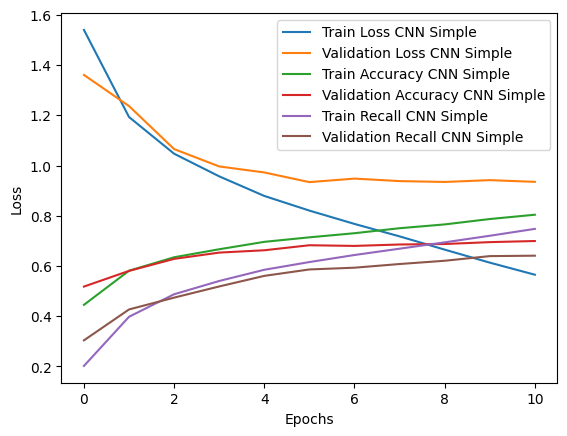

In [ ]:
# Entraînement du 1er model
history_1 = model.fit(
    x_train, y_train_c,
    validation_data=(x_val, y_val_c),
    epochs=22,
    batch_size=64,
    callbacks=[early_stopping]
)

plt.plot(history_1.history['loss'], label='Train Loss CNN Simple')
plt.plot(history_1.history['val_loss'], label='Validation Loss CNN Simple')
plt.plot(history_1.history['accuracy'], label='Train Accuracy CNN Simple')
plt.plot(history_1.history['val_accuracy'], label='Validation Accuracy CNN Simple')
plt.plot(history_1.history['recall'], label='Train Recall CNN Simple')
plt.plot(history_1.history['val_recall'], label='Validation Recall CNN Simple')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()


Epoch 1/22
625/625 ━━━━━━━━━━━━━━━━━━━━ 257s 405ms/step - accuracy: 0.2446 - loss: 4.0662 - recall: 0.0556 - val_accuracy: 0.4626 - val_loss: 1.5859 - val_recall: 0.2621
Epoch 2/22
625/625 ━━━━━━━━━━━━━━━━━━━━ 257s 412ms/step - accuracy: 0.5116 - loss: 1.5077 - recall: 0.3104 - val_accuracy: 0.5244 - val_loss: 1.4771 - val_recall: 0.3839
Epoch 3/22
625/625 ━━━━━━━━━━━━━━━━━━━━ 260s 416ms/step - accuracy: 0.6256 - loss: 1.2238 - recall: 0.4682 - val_accuracy: 0.6117 - val_loss: 1.2303 - val_recall: 0.4620
Epoch 4/22
625/625 ━━━━━━━━━━━━━━━━━━━━ 255s 408ms/step - accuracy: 0.6832 - loss: 1.0705 - recall: 0.5560 - val_accuracy: 0.6827 - val_loss: 1.0779 - val_recall: 0.5954
Epoch 5/22
625/625 ━━━━━━━━━━━━━━━━━━━━ 273s 437ms/step - accuracy: 0.7280 - loss: 0.9622 - recall: 0.6190 - val_accuracy: 0.7121 - val_loss: 1.0160 - val_recall: 0.6199
Epoch 6/22
625/625 ━━━━━━━━━━━━━━━━━━━━ 264s 423ms/step - accuracy: 0.7493 - loss: 0.8909 - recall: 0.6547 - val_accuracy: 0.7655 - val_loss: 0.8326 -

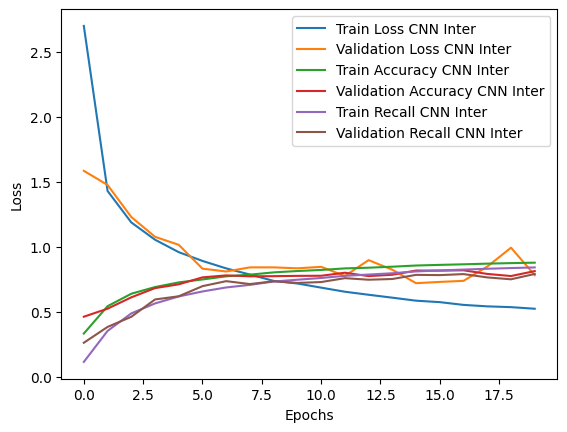

In [8]:
# Entraînement model_2
history_intermediate = model_2.fit(
    x_train, y_train_c,
    validation_data=(x_val, y_val_c),
    epochs=22,
    batch_size=64,
    callbacks=[early_stopping]
)
plt.plot(history_intermediate.history['loss'], label='Train Loss CNN Inter')
plt.plot(history_intermediate.history['val_loss'], label='Validation Loss CNN Inter')
plt.plot(history_intermediate.history['accuracy'], label='Train Accuracy CNN Inter')
plt.plot(history_intermediate.history['val_accuracy'], label='Validation Accuracy CNN Inter')
plt.plot(history_intermediate.history['recall'], label='Train Recall CNN Inter')
plt.plot(history_intermediate.history['val_recall'], label='Validation Recall CNN Inter')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

In [ ]:
callbacks = [
    EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True),
]

# Entraîner le MCDNN
history_mcdnn = mcdnn.fit(
    x_train, y_train_c,
    validation_data=(x_val, y_val_c),
    epochs=30,
    batch_size=64,
    callbacks=callbacks
)

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history_mcdnn.history['accuracy'], label='Train Accuracy')
plt.plot(history_mcdnn.history['val_accuracy'], label='Val Accuracy')
plt.title('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_mcdnn.history['loss'], label='Train Loss')
plt.plot(history_mcdnn.history['val_loss'], label='Val Loss')
plt.title('Loss')
plt.legend()
plt.show()

Epoch 1/30
 28/625 ━━━━━━━━━━━━━━━━━━━━ 6:14 628ms/step - accuracy: 0.2286 - loss: 2.1461 - recall: 0.0140

In [ ]:
#Evaluation du 1er modèle
model_names_single = ["CNN Classique (model)"]
models_to_evaluate_single = [model] 

results_single = []

print("Évaluation du modèle CNN Classique en cours...")

for i, current_model in enumerate(models_to_evaluate_single):
    model_name = model_names_single[i]
    print(f"Évaluation de : {model_name}")

    train_loss, train_accuracy, train_recall = current_model.evaluate(x_train, y_train_c, verbose=0)
    results_single.append({
        "Modèle": model_name,
        "Set": "Train",
        "Loss": f"{train_loss:.4f}",
        "Accuracy": f"{train_accuracy:.4f}",
        "Recall": f"{train_recall:.4f}"
    })

    val_loss, val_accuracy, val_recall = current_model.evaluate(x_val, y_val_c, verbose=0)
    results_single.append({
        "Modèle": model_name,
        "Set": "Validation",
        "Loss": f"{val_loss:.4f}",
        "Accuracy": f"{val_accuracy:.4f}",
        "Recall": f"{val_recall:.4f}"
    })


    test_loss, test_accuracy, test_recall = current_model.evaluate(x_test, y_test_c, verbose=0)
    results_single.append({
        "Modèle": model_name,
        "Set": "Test",
        "Loss": f"{test_loss:.4f}",
        "Accuracy": f"{test_accuracy:.4f}",
        "Recall": f"{test_recall:.4f}"
    })


df_results_single = pd.DataFrame(results_single)

print("\n\nTableau Récapitulatif des Performances (CNN Classique):\n")
print(df_results_single.to_markdown(index=False))



Évaluation du modèle CNN Classique en cours...
Évaluation de : CNN Classique (model)


Tableau Récapitulatif des Performances (CNN Classique):

| Modèle                | Set        |   Loss |   Accuracy |   Recall |
|:----------------------|:-----------|-------:|-----------:|---------:|
| CNN Classique (model) | Train      | 0.4982 |     0.8347 |   0.7674 |
| CNN Classique (model) | Validation | 0.8714 |     0.7086 |   0.6434 |
| CNN Classique (model) | Test       | 0.8893 |     0.7042 |   0.6395 |


In [9]:
#Evaluation du 2ème modèle
model_names_single = ["CNN Intermédiaire"]
models_to_evaluate_single = [model_2] 

results_single = []

print("Évaluation du modèle CNN Classique en cours...")

for i, current_model in enumerate(models_to_evaluate_single):
    model_name = model_names_single[i]
    print(f"Évaluation de : {model_name}")

    
    train_loss, train_accuracy, train_recall = current_model.evaluate(x_train, y_train_c, verbose=0)
    results_single.append({
        "Modèle": model_name,
        "Set": "Train",
        "Loss": f"{train_loss:.4f}",
        "Accuracy": f"{train_accuracy:.4f}",
        "Recall": f"{train_recall:.4f}"
    })

    
    val_loss, val_accuracy, val_recall = current_model.evaluate(x_val, y_val_c, verbose=0)
    results_single.append({
        "Modèle": model_name,
        "Set": "Validation",
        "Loss": f"{val_loss:.4f}",
        "Accuracy": f"{val_accuracy:.4f}",
        "Recall": f"{val_recall:.4f}"
    })

    
    test_loss, test_accuracy, test_recall = current_model.evaluate(x_test, y_test_c, verbose=0)
    results_single.append({
        "Modèle": model_name,
        "Set": "Test",
        "Loss": f"{test_loss:.4f}",
        "Accuracy": f"{test_accuracy:.4f}",
        "Recall": f"{test_recall:.4f}"
    })


df_results_single = pd.DataFrame(results_single)

print("\n\nTableau Récapitulatif des Performances (CNN Intermédiaire):\n")
print(df_results_single.to_markdown(index=False))



Évaluation du modèle CNN Classique en cours...
Évaluation de : CNN Intermédiaire


Tableau Récapitulatif des Performances (CNN Intermédiaire):

| Modèle            | Set        |   Loss |   Accuracy |   Recall |
|:------------------|:-----------|-------:|-----------:|---------:|
| CNN Intermédiaire | Train      | 0.4219 |     0.9049 |   0.8758 |
| CNN Intermédiaire | Validation | 0.7208 |     0.8181 |   0.7848 |
| CNN Intermédiaire | Test       | 0.7549 |     0.8124 |   0.7773 |


In [ ]:
#Evaluation du 3ème modèle
model_names_single = ["MCDNN"]
models_to_evaluate_single = [mcdnn] 

results_single = []

print("Évaluation du modèle CNN Classique en cours...")

for i, current_model in enumerate(models_to_evaluate_single):
    model_name = model_names_single[i]
    print(f"Évaluation de : {model_name}")

    
    train_loss, train_accuracy, train_recall = current_model.evaluate(x_train, y_train_c, verbose=0)
    results_single.append({
        "Modèle": model_name,
        "Set": "Train",
        "Loss": f"{train_loss:.4f}",
        "Accuracy": f"{train_accuracy:.4f}",
        "Recall": f"{train_recall:.4f}"
    })

    
    val_loss, val_accuracy, val_recall = current_model.evaluate(x_val, y_val_c, verbose=0)
    results_single.append({
        "Modèle": model_name,
        "Set": "Validation",
        "Loss": f"{val_loss:.4f}",
        "Accuracy": f"{val_accuracy:.4f}",
        "Recall": f"{val_recall:.4f}"
    })

    
    test_loss, test_accuracy, test_recall = current_model.evaluate(x_test, y_test_c, verbose=0)
    results_single.append({
        "Modèle": model_name,
        "Set": "Test",
        "Loss": f"{test_loss:.4f}",
        "Accuracy": f"{test_accuracy:.4f}",
        "Recall": f"{test_recall:.4f}"
    })


df_results_single = pd.DataFrame(results_single)

print("\n\nTableau Récapitulatif des Performances (MCDNN):\n")
print(df_results_single.to_markdown(index=False))



In [ ]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


# Redimensionner les images pour qu'elles correspondent à l'entrée du réseau préentraîné
# MobileNetV2 attend des images de taille 224x224 par défaut
x_train_resized = tf.image.resize(x_train, (96, 96))
x_val_resized = tf.image.resize(x_val, (96, 96))
x_test_resized = tf.image.resize(x_test, (96, 96))

# Charger le modèle préentraîné (sans les couches de classification supérieures)
base_model = MobileNetV2(
    input_shape=(96, 96, 3),
    include_top=False,
    weights='imagenet'
)

# on gèle les couches du modèle préentraîné
base_model.trainable = False

# ajoute des couches personnalisées pour l'adaptation à CIFAR-10
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
predictions = Dense(10, activation='softmax')(x)


hybrid_model = Model(inputs=base_model.input, outputs=predictions)

hybrid_model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy','recall']
)


callbacks = [
    EarlyStopping(patience=5, restore_best_weights=True)
]

# première phase avec base_model gelé
history = hybrid_model.fit(
    x_train_resized, y_train_c,
    validation_data=(x_val_resized, y_val_c),
    epochs=15,
    batch_size=64,
    callbacks=callbacks
)


Epoch 1/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 0.6577 - loss: 1.0726 - recall: 0.5982

625/625 ━━━━━━━━━━━━━━━━━━━━ 62s 94ms/step - accuracy: 0.6578 - loss: 1.0722 - recall: 0.5983 - val_accuracy: 0.7854 - val_loss: 0.6088 - val_recall: 0.7333
Epoch 2/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 0.7793 - loss: 0.6403 - recall: 0.7219

625/625 ━━━━━━━━━━━━━━━━━━━━ 59s 94ms/step - accuracy: 0.7793 - loss: 0.6403 - recall: 0.7219 - val_accuracy: 0.7965 - val_loss: 0.5801 - val_recall: 0.7476
Epoch 3/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 0.7913 - loss: 0.5973 - recall: 0.7389

625/625 ━━━━━━━━━━━━━━━━━━━━ 56s 89ms/step - accuracy: 0.7913 - loss: 0.5973 - recall: 0.7389 - val_accuracy: 0.8048 - val_loss: 0.5639 - val_recall: 0.7522
Epoch 4/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 0.8025 - loss: 0.5637 - recall: 0.7517

625/625 ━━━━━━━━━━━━━━━━━━━━ 54s 87ms/step - accuracy: 0.8025 - loss: 0.5637 - recall: 0.7517 - val_accuracy: 0.8076 - val_loss: 0.5572 - val_recall: 0.7546
Epoch 5/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 0.8106 - loss: 0.5432 - recall: 0.7587

625/625 ━━━━━━━━━━━━━━━━━━━━ 54s 87ms/step - accuracy: 0.8106 - loss: 0.5432 - recall: 0.7587 - val_accuracy: 0.8063 - val_loss: 0.5544 - val_recall: 0.7621
Epoch 6/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 0.8125 - loss: 0.5359 - recall: 0.7639

625/625 ━━━━━━━━━━━━━━━━━━━━ 56s 90ms/step - accuracy: 0.8125 - loss: 0.5359 - recall: 0.7639 - val_accuracy: 0.8099 - val_loss: 0.5514 - val_recall: 0.7688
Epoch 7/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 61s 97ms/step - accuracy: 0.8180 - loss: 0.5240 - recall: 0.7722 - val_accuracy: 0.7964 - val_loss: 0.5904 - val_recall: 0.7511
Epoch 8/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 61s 97ms/step - accuracy: 0.8225 - loss: 0.5069 - recall: 0.7768 - val_accuracy: 0.8005 - val_loss: 0.5802 - val_recall: 0.7635
Epoch 9/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 58s 94ms/step - accuracy: 0.8167 - loss: 0.5199 - recall: 0.7710 - val_accuracy: 0.8087 - val_loss: 0.5549 - val_recall: 0.7692
Epoch 10/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 0.8223 - loss: 0.5056 - recall: 0.7799

625/625 ━━━━━━━━━━━━━━━━━━━━ 58s 93ms/step - accuracy: 0.8223 - loss: 0.5056 - recall: 0.7799 - val_accuracy: 0.8100 - val_loss: 0.5502 - val_recall: 0.7745
Epoch 11/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 58s 94ms/step - accuracy: 0.8282 - loss: 0.4916 - recall: 0.7867 - val_accuracy: 0.8107 - val_loss: 0.5584 - val_recall: 0.7736
Epoch 12/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy: 0.8284 - loss: 0.4838 - recall: 0.7879

625/625 ━━━━━━━━━━━━━━━━━━━━ 57s 92ms/step - accuracy: 0.8284 - loss: 0.4838 - recall: 0.7879 - val_accuracy: 0.8110 - val_loss: 0.5436 - val_recall: 0.7760
Epoch 13/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 60s 95ms/step - accuracy: 0.8320 - loss: 0.4761 - recall: 0.7915 - val_accuracy: 0.8076 - val_loss: 0.5635 - val_recall: 0.7723
Epoch 14/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 57s 92ms/step - accuracy: 0.8395 - loss: 0.4590 - recall: 0.8001 - val_accuracy: 0.8084 - val_loss: 0.5550 - val_recall: 0.7706
Epoch 15/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 58s 93ms/step - accuracy: 0.8389 - loss: 0.4572 - recall: 0.8011 - val_accuracy: 0.8112 - val_loss: 0.5484 - val_recall: 0.7728


In [19]:
# Fine-tuning : dégeler certaines couches du modèle préentraîné
base_model.trainable = True
# on gèle seulement les premières couches
for layer in base_model.layers[:-10]:
    layer.trainable = False

# Recompiler 
hybrid_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=5e-5),
    loss='categorical_crossentropy',
    metrics=['accuracy','recall']
)

# entraînement avec fine-tuning
history_fine = hybrid_model.fit(
    x_train_resized, y_train_c,
    validation_data=(x_val_resized, y_val_c),
    epochs=20,
    batch_size=32,
    callbacks=callbacks
)

Epoch 1/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 115s 87ms/step - accuracy: 0.8979 - loss: 0.2936 - recall: 0.8747 - val_accuracy: 0.8328 - val_loss: 0.5122 - val_recall: 0.8148
Epoch 2/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 106s 85ms/step - accuracy: 0.9131 - loss: 0.2536 - recall: 0.8926 - val_accuracy: 0.8346 - val_loss: 0.5196 - val_recall: 0.8179
Epoch 3/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 108s 86ms/step - accuracy: 0.9202 - loss: 0.2281 - recall: 0.9025 - val_accuracy: 0.8344 - val_loss: 0.5371 - val_recall: 0.8207
Epoch 4/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 108s 86ms/step - accuracy: 0.9348 - loss: 0.1937 - recall: 0.9194 - val_accuracy: 0.8353 - val_loss: 0.5445 - val_recall: 0.8214
Epoch 5/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 107s 86ms/step - accuracy: 0.9380 - loss: 0.1808 - recall: 0.9244 - val_accuracy: 0.8346 - val_loss: 0.5469 - val_recall: 0.8222
Epoch 6/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 107s 86ms/step - accuracy: 0.9475 - loss: 0.1593 - recall: 0.9366 - val_accuracy: 0.8364 - val_loss: 0.

In [20]:
#Evaluation du modèle hybride
model_names_single = ["MobileNetv2_Fine-tuné"]
models_to_evaluate_single = [hybrid_model] 

results_single = []

print("Évaluation du modèle hybride en cours...")

for i, current_model in enumerate(models_to_evaluate_single):
    model_name = model_names_single[i]
    print(f"Évaluation de : {model_name}")

    
    train_loss, train_accuracy, train_recall = current_model.evaluate(x_train_resized, y_train_c, verbose=0)
    results_single.append({
        "Modèle": model_name,
        "Set": "Train",
        "Loss": f"{train_loss:.4f}",
        "Accuracy": f"{train_accuracy:.4f}",
        "Recall": f"{train_recall:.4f}"
    })

    
    val_loss, val_accuracy, val_recall = current_model.evaluate(x_val_resized, y_val_c, verbose=0)
    results_single.append({
        "Modèle": model_name,
        "Set": "Validation",
        "Loss": f"{val_loss:.4f}",
        "Accuracy": f"{val_accuracy:.4f}",
        "Recall": f"{val_recall:.4f}"
    })

    
    test_loss, test_accuracy, test_recall = current_model.evaluate(x_test_resized, y_test_c, verbose=0)
    results_single.append({
        "Modèle": model_name,
        "Set": "Test",
        "Loss": f"{test_loss:.4f}",
        "Accuracy": f"{test_accuracy:.4f}",
        "Recall": f"{test_recall:.4f}"
    })


df_results_single = pd.DataFrame(results_single)

print("\n\nTableau Récapitulatif des Performances (MobileNetv2 Hybride):\n")
print(df_results_single.to_markdown(index=False))



Évaluation du modèle hybride en cours...
Évaluation de : MobileNetv2_Fine-tuné


Tableau Récapitulatif des Performances (MobileNetv2 Hybride):

| Modèle                | Set        |   Loss |   Accuracy |   Recall |
|:----------------------|:-----------|-------:|-----------:|---------:|
| MobileNetv2_Fine-tuné | Train      | 0.1171 |     0.9681 |   0.9566 |
| MobileNetv2_Fine-tuné | Validation | 0.5122 |     0.8328 |   0.8148 |
| MobileNetv2_Fine-tuné | Test       | 0.5103 |     0.8354 |   0.8161 |
